This notebook uses the Scientific Python (scipy) stack tools to generate flow duration curves from current USGS NWIS data.

Using recipes from this notebook, you can make:
* USGS Station Summaries
* Flow duration curves
* Iterative import and compilation of USGS station information and data
* boxplots using pandas
* iterative charts (one monthly summary boxplot per station)
* Gantt charts of USGS stations

## Background

Check out this for some great `pandas` applications:
http://earthpy.org/time_series_analysis_with_pandas_part_2.html

In [1]:
%matplotlib inline
import pandas as pd
import platform
import sys
#import xmltodict
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(matplotlib.__version__))

Operating System Windows 7
Python Version 2.7.8 (default, Jun 30 2014, 16:03:49) [MSC v.1500 32 bit (Intel)]
Pandas Version 0.17.1
Numpy Version 1.10.4
Matplotlib Version 1.5.1


This following the suggested import call for the well application function.

In [3]:
import wellapplication as wa

In [4]:
wa.__version__

'0.2.4'

In [13]:
def createTable(model):
    t=Toplevel()
    app = App(t)
    master = app.main
    table = TableCanvas(master, model,rowheaderwidth=50)
    table.createTableFrame()
    return table

Call function class usgs and assign it as USGS.  This will allow for the implementation of all of the usgs functions.  This function class allows for the import of usgs data.

In [5]:
HUClist = ['16010203','16010202']

In [6]:
USGS = wa.usgs()

Import list of stations based on Cache Valley HUCS. The function `getStationsfromHUC` will import a list of stations from a list of HUCs.

In [7]:
stations = USGS.getStationsfromHUC(HUClist)

Import site data from HUCS. The function `getStationsInfoFromHUC` will import a list of stations information from a list of HUCs and save it in a Pandas DataFrame.

In [8]:
siteinfo = USGS.getStationInfoFromHUC(HUClist)

Inspect columns of imported site data

In [ ]:
siteinfo.columns

Reproject Lat Long into UTM X and Y.  These functions use an import from the `pyproj` package.

In [ ]:
siteinfo['UTM_X'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: wa.avgMeths.projx(x),1)
siteinfo['UTM_Y']= siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: wa.avgMeths.projy(x),1)

Use the `getelev` function to call the point elevation service of the USGS. The Elevation Point Query Service <a href=http://ned.usgs.gov/epqs/> EPQS </a>

In [16]:
siteinfo['Elev'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: USGS.getelev(x),1)

The `getWLfromHUC` function downloads all of the data for a huc from the <a href=http://waterservices.usgs.gov/rest/GW-Levels-Test-Tool.html> USGS Groundwater Service Tool</a> and outputs it into a Pandas DataFrame.

In [9]:
data = USGS.getWLfromHUC(HUClist)

The `cleanGWL` function does a simple query on the USGS Water Level DataFrame to remove all of the <a href=http://help.waterdata.usgs.gov/codes-and-parameters/water-level-site-status-codes-lev_status_cd> lev_status_cd</a> value codes that signify error.

In [10]:
data = USGS.cleanGWL(data)

In [11]:
stationWL = pd.merge(data, siteinfo, on='site_no', how='left')

In [12]:
stationWL['wlelev'] = stationWL[['lev_va','Elev']].apply(lambda x: wa.avgMeths.getwlelev(x),1)

KeyError: "['Elev'] not in index"

In [13]:
stationWL['date'], stationWL['Year'], stationWL['Month'] = zip(*stationWL['lev_dt'].apply(lambda x: wa.avgMeths.getyrmnth(x),1))

The HUCdf function can produce an average monthly changes over time

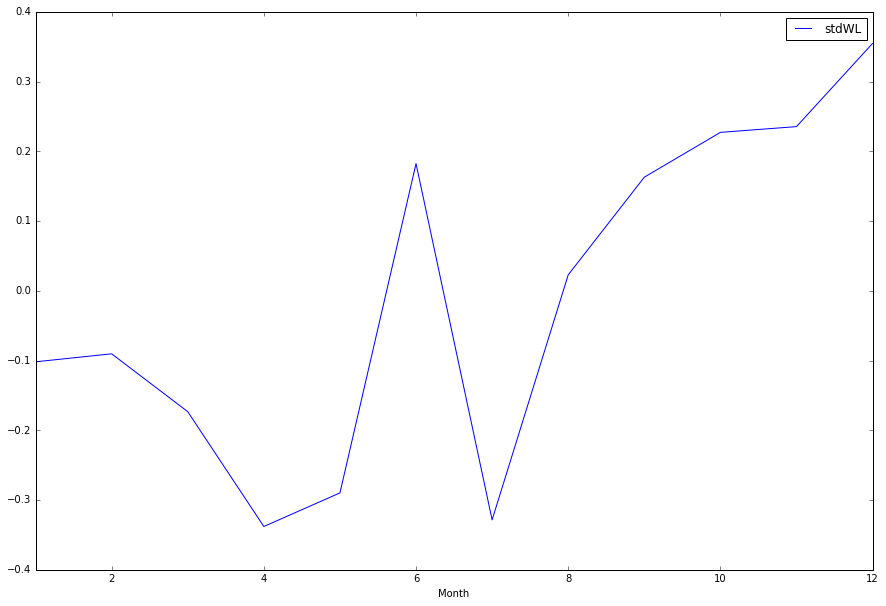

In [14]:
df1, df2 = USGS.HUCdf(16020301)

In [17]:
df1

,cnt,standard,median,err,mean,meanpluserr,meanminuserr
date,,,,,,,
1934-10-15,1,NaN,0.403452,0.000000,0.403452,0.403452,0.403452
1936-05-15,1,NaN,-0.846486,0.000000,-0.846486,-0.846486,-0.846486
1936-11-15,1,NaN,-1.185011,0.000000,-1.185011,-1.185011,-1.185011
1937-11-15,3,1.806782,1.681391,0.963818,0.741723,1.705540,-0.222095
1938-11-15,3,1.660492,1.196559,0.885780,0.367409,1.253189,-0.518371
1939-11-15,3,1.334251,1.342969,0.711749,0.661699,1.373448,-0.050049
1940-09-15,3,1.278332,1.309367,0.681919,0.782877,1.464796,0.100958
1941-09-15,2,0.312336,0.138129,0.216438,0.138129,0.354567,-0.078308
1942-08-15,2,0.079251,-0.969949,0.054918,-0.969949,-0.915031,-1.024867


The HUCplot function will produce two charts showing the HUC-wide groundwater level trends over time.

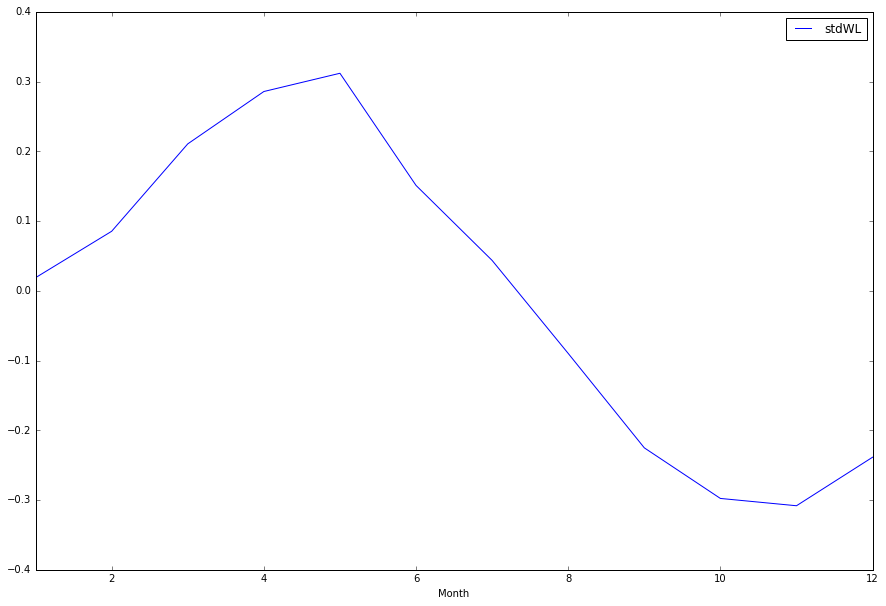

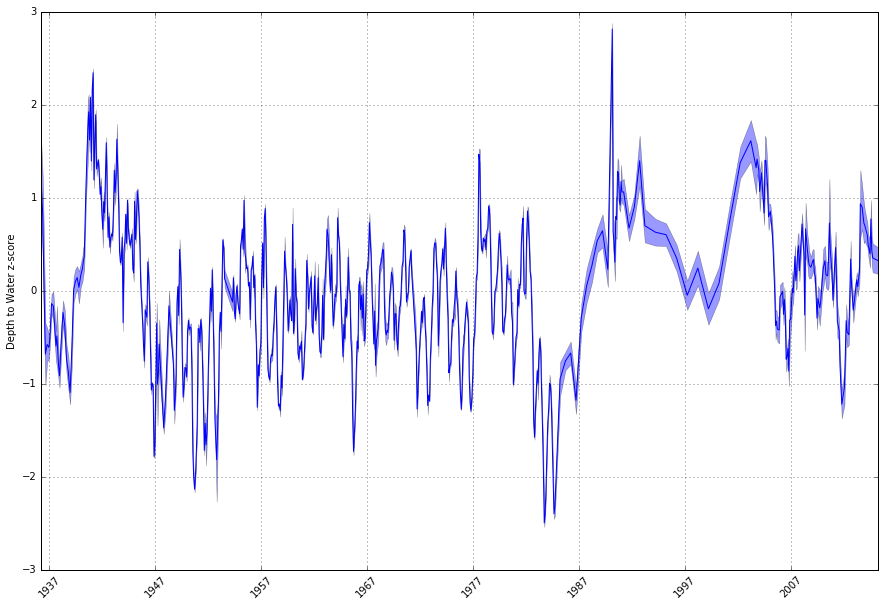

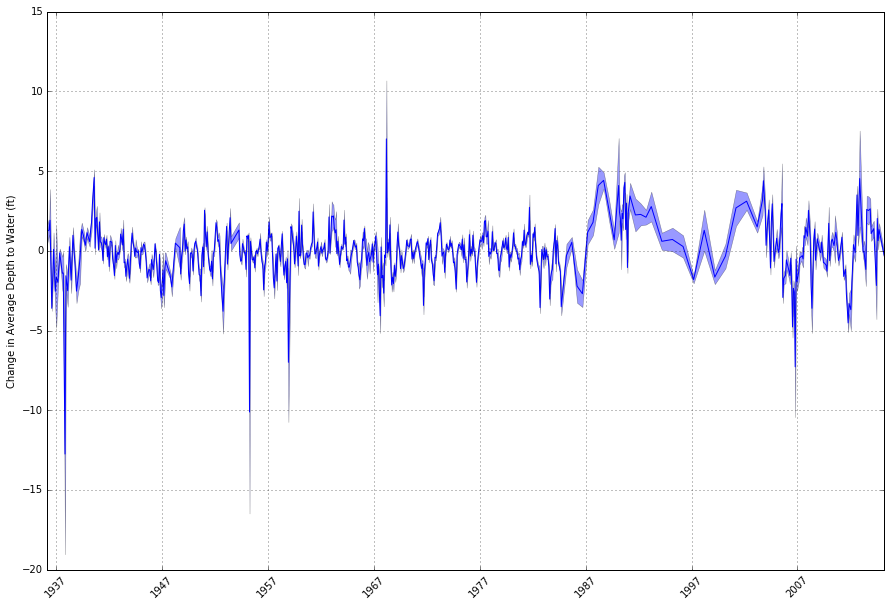

In [7]:
USGS.HUCplot(16010203) #cedar city valley